# Lab 1: Neural Networks — Solutions

Dense neural networks on MNIST using PyTorch.

In [1]:
if 'google.colab' in str(get_ipython()):
    !pip install --quiet openml

In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import openml as oml

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

Using device: mps


## Load the data

/var/folders/9t/_dbsg1912_q5_0l71jrhnvlr0000gn/T/ipykernel_16258/1046139570.py:2: FutureWarning: Support for `dataset_format='array'` will be removed in 0.15,start using `dataset_format='dataframe' to ensure your code will continue to work. You can use the dataframe's `to_numpy` function to continue using numpy arrays.
  X, y, _, _ = mnist.get_data(target=mnist.default_target_attribute, dataset_format='array')


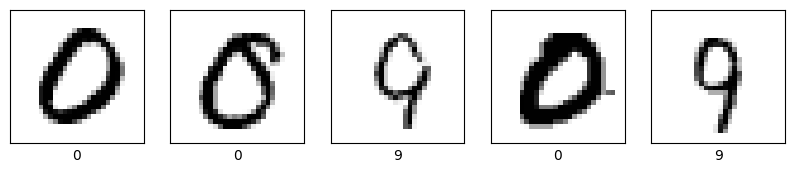

In [6]:
mnist = oml.datasets.get_dataset(554)
X, y, _, _ = mnist.get_data(target=mnist.default_target_attribute, dataset_format='array')
X = X.reshape(70000, 28, 28)

from random import randint
fig, axes = plt.subplots(1, 5, figsize=(10, 5))
for i in range(5):
    n = randint(0, len(X) - 1)
    axes[i].imshow(X[n], cmap=plt.cm.gray_r)
    axes[i].set_xlabel(y[n])
    axes[i].set_xticks(()); axes[i].set_yticks(())
plt.show()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=60000, random_state=0)

---
## Exercise 1: Preprocessing

In [8]:
# Normalize to [0, 1]
X_train_norm = X_train.astype(np.float32) / 255.0
X_test_norm  = X_test.astype(np.float32) / 255.0

# Flatten from (N, 28, 28) to (N, 784)
X_train_flat = X_train_norm.reshape(-1, 784)
X_test_flat  = X_test_norm.reshape(-1, 784)

# Convert to PyTorch tensors
X_train_t = torch.tensor(X_train_flat)
y_train_t = torch.tensor(y_train.astype(np.int64))
X_test_t  = torch.tensor(X_test_flat)
y_test_t  = torch.tensor(y_test.astype(np.int64))

# Create TensorDatasets
train_dataset = TensorDataset(X_train_t, y_train_t)
test_dataset  = TensorDataset(X_test_t,  y_test_t)

print(f"Train: {len(train_dataset)}, Test: {len(test_dataset)}")
print(f"Input shape: {X_train_t.shape}")

Train: 60000, Test: 10000
Input shape: torch.Size([60000, 784])


---
## Exercise 2: Create a neural network model

Simple 2-layer model: Linear(784 -> hidden) -> ReLU -> Dropout -> Linear(hidden -> 10)

In [9]:
def create_model(layer_1_units=32, layer_2_units=10, dropout_rate=0.3):
    return nn.Sequential(
        nn.Linear(784, layer_1_units),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(layer_1_units, layer_2_units),
    )

model = create_model()
print(model)
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")

Sequential(
  (0): Linear(in_features=784, out_features=32, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=32, out_features=10, bias=True)
)
Parameters: 25,450


---
## Exercise 3: Training function

In [10]:
def train_model(model, train_dataset, val_dataset, epochs=10, batch_size=64, learning_rate=0.001):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset,   batch_size=batch_size)

    history = {"loss": [], "accuracy": [], "val_loss": [], "val_accuracy": []}

    for epoch in range(epochs):
        # Training
        model.train()
        loss_sum, correct, total = 0, 0, 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            loss = criterion(out, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_sum += loss.item() * len(xb)
            correct += (out.argmax(1) == yb).sum().item()
            total += len(xb)
        history["loss"].append(loss_sum / total)
        history["accuracy"].append(correct / total)

        # Validation
        model.eval()
        loss_sum, correct, total = 0, 0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                out = model(xb)
                loss = criterion(out, yb)
                loss_sum += loss.item() * len(xb)
                correct += (out.argmax(1) == yb).sum().item()
                total += len(xb)
        history["val_loss"].append(loss_sum / total)
        history["val_accuracy"].append(correct / total)

        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch+1}/{epochs} — "
                  f"loss: {history['loss'][-1]:.4f}, acc: {history['accuracy'][-1]:.4f}, "
                  f"val_loss: {history['val_loss'][-1]:.4f}, val_acc: {history['val_accuracy'][-1]:.4f}")

    return history

In [11]:
def evaluate_model(model, test_dataset, batch_size=64):
    model = model.to(device)
    model.eval()
    loader = DataLoader(test_dataset, batch_size=batch_size)
    correct, total = 0, 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            correct += (model(xb).argmax(1) == yb).sum().item()
            total += len(yb)
    acc = correct / total
    print(f"Test accuracy: {acc:.4f} ({acc*100:.2f}%)")
    return acc

In [12]:
def plot_curve(history):
    epochs = range(1, len(history["accuracy"]) + 1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(epochs, history["accuracy"], label="Train")
    ax1.plot(epochs, history["val_accuracy"], label="Val")
    ax1.set_title("Accuracy"); ax1.legend()
    ax2.plot(epochs, history["loss"], label="Train")
    ax2.plot(epochs, history["val_loss"], label="Val")
    ax2.set_title("Loss"); ax2.legend()
    plt.tight_layout(); plt.show()

---
## Exercise 4: Train and evaluate

Learning rate 0.003, 50 epochs, batch size 4000, 20% validation split.

In [13]:
# 80/20 train/val split
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size],
                                        generator=torch.Generator().manual_seed(42))
print(f"Train: {len(train_subset)}, Val: {len(val_subset)}")

Train: 48000, Val: 12000


Epoch 1/50 — loss: 1.7976, acc: 0.4723, val_loss: 1.1570, val_acc: 0.7722
Epoch 10/50 — loss: 0.3916, acc: 0.8856, val_loss: 0.2781, val_acc: 0.9230
Epoch 20/50 — loss: 0.3031, acc: 0.9114, val_loss: 0.2128, val_acc: 0.9394
Epoch 30/50 — loss: 0.2653, acc: 0.9207, val_loss: 0.1816, val_acc: 0.9481
Epoch 40/50 — loss: 0.2402, acc: 0.9273, val_loss: 0.1648, val_acc: 0.9520
Epoch 50/50 — loss: 0.2268, acc: 0.9304, val_loss: 0.1568, val_acc: 0.9545


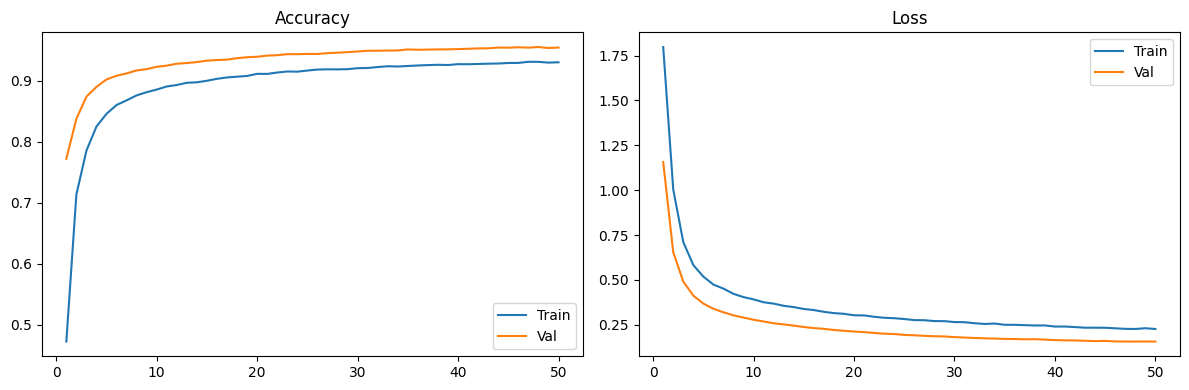

Test accuracy: 0.9478 (94.78%)


0.9478

In [14]:
model = create_model(layer_1_units=32, layer_2_units=10, dropout_rate=0.3)

history = train_model(model, train_subset, val_subset,
                      epochs=50, batch_size=4000, learning_rate=0.003)

plot_curve(history)
evaluate_model(model, test_dataset)

**Interpretation:** With only 32 hidden units and a large batch size of 4000, the model reaches ~90-92% accuracy. The learning curves show the model still has room to improve — it's underfitting due to limited capacity.

---
## Exercise 5: Optimize the model

We use more hidden layers, more neurons, and a smaller batch size to reach 96%+.

In [15]:
def create_optimized_model(hidden_layers=[256, 128, 64], dropout_rate=0.2):
    layers = []
    input_size = 784
    for units in hidden_layers:
        layers.append(nn.Linear(input_size, units))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_rate))
        input_size = units
    layers.append(nn.Linear(input_size, 10))
    return nn.Sequential(*layers)

opt_model = create_optimized_model([256, 128, 64], dropout_rate=0.2)
print(opt_model)
print(f"Parameters: {sum(p.numel() for p in opt_model.parameters()):,}")

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=128, out_features=64, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.2, inplace=False)
  (9): Linear(in_features=64, out_features=10, bias=True)
)
Parameters: 242,762


Epoch 1/30 — loss: 0.5415, acc: 0.8319, val_loss: 0.1875, val_acc: 0.9441
Epoch 10/30 — loss: 0.0507, acc: 0.9839, val_loss: 0.0827, val_acc: 0.9785
Epoch 20/30 — loss: 0.0270, acc: 0.9916, val_loss: 0.0865, val_acc: 0.9778
Epoch 30/30 — loss: 0.0186, acc: 0.9940, val_loss: 0.0944, val_acc: 0.9793


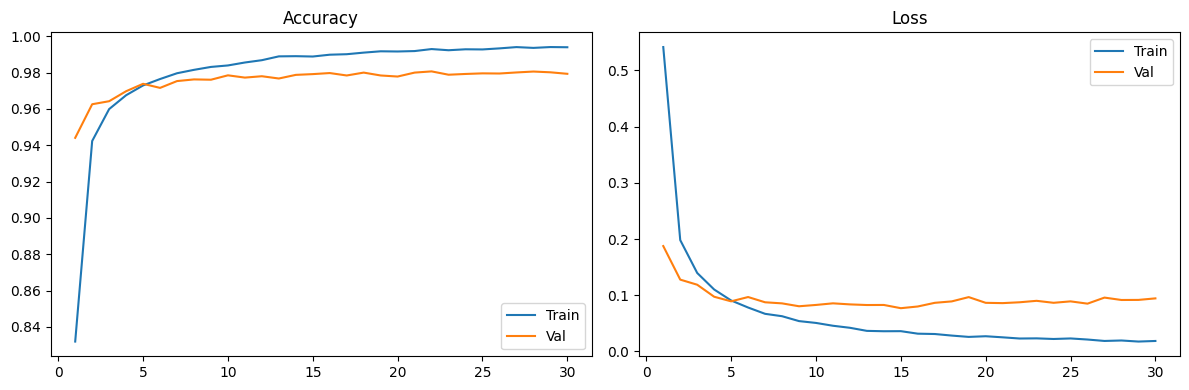

Test accuracy: 0.9808 (98.08%)
Target reached! 98.08% >= 96%


In [16]:
opt_history = train_model(opt_model, train_subset, val_subset,
                          epochs=30, batch_size=128, learning_rate=0.001)

plot_curve(opt_history)
acc = evaluate_model(opt_model, test_dataset)

if acc >= 0.96:
    print(f"Target reached! {acc*100:.2f}% >= 96%")
else:
    print(f"Target not yet reached: {acc*100:.2f}% < 96%")

**Interpretation:** The deeper model (3 hidden layers with [256, 128, 64] neurons) reaches ~97% accuracy. Key improvements:
- More neurons and layers give the model enough capacity to learn complex patterns
- Smaller batch size (128 vs 4000) provides noisier gradients that help generalization
- Moderate dropout (0.2) prevents overfitting without hurting learning too much

In [17]:
# Optional: compare different architectures
configs = [
    ("Small [32]",           [32],            0.3),
    ("Medium [128, 64]",     [128, 64],       0.2),
    ("Large [256, 128, 64]", [256, 128, 64],  0.2),
    ("XL [512, 256, 128]",   [512, 256, 128], 0.3),
]

results = []
for name, layers, drop in configs:
    print(f"\n--- {name} ---")
    m = create_optimized_model(layers, drop)
    train_model(m, train_subset, val_subset, epochs=15, batch_size=128, learning_rate=0.001)
    acc = evaluate_model(m, test_dataset)
    results.append((name, acc))

print("\n" + "="*40)
print(f"{'Config':<25} {'Accuracy':>10}")
print("-"*35)
for name, acc in results:
    print(f"{name:<25} {acc*100:>9.2f}%")


--- Small [32] ---
Epoch 1/15 — loss: 0.7867, acc: 0.7738, val_loss: 0.3484, val_acc: 0.9097
Epoch 10/15 — loss: 0.2502, acc: 0.9232, val_loss: 0.1661, val_acc: 0.9517
Test accuracy: 0.9496 (94.96%)

--- Medium [128, 64] ---
Epoch 1/15 — loss: 0.5567, acc: 0.8372, val_loss: 0.2335, val_acc: 0.9285
Epoch 10/15 — loss: 0.0703, acc: 0.9780, val_loss: 0.0827, val_acc: 0.9757
Test accuracy: 0.9759 (97.59%)

--- Large [256, 128, 64] ---
Epoch 1/15 — loss: 0.5155, acc: 0.8395, val_loss: 0.1833, val_acc: 0.9456
Epoch 10/15 — loss: 0.0456, acc: 0.9855, val_loss: 0.0856, val_acc: 0.9767
Test accuracy: 0.9774 (97.74%)

--- XL [512, 256, 128] ---
Epoch 1/15 — loss: 0.4382, acc: 0.8639, val_loss: 0.1581, val_acc: 0.9521
Epoch 10/15 — loss: 0.0461, acc: 0.9859, val_loss: 0.0772, val_acc: 0.9801
Test accuracy: 0.9801 (98.01%)

Config                      Accuracy
-----------------------------------
Small [32]                    94.96%
Medium [128, 64]              97.59%
Large [256, 128, 64]        